In [368]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from pathlib import Path

In [369]:
img_labels = []
directory_path = Path('YogaPoses')
for file_path in directory_path.glob('*'):
    img_labels.append(str(file_path).split('\\')[-1])
    
labels_to_digits = {}
digits_to_labels = {}
for i, elem in enumerate(img_labels):
    labels_to_digits[elem] = i
    digits_to_labels[i] = elem
labels_to_digits, digits_to_labels

({'Downdog': 0, 'Goddess': 1, 'Plank': 2, 'Tree': 3, 'Warrior2': 4},
 {0: 'Downdog', 1: 'Goddess', 2: 'Plank', 3: 'Tree', 4: 'Warrior2'})

In [370]:
df = pd.read_csv('body_landmarks.csv')

In [371]:
X = np.array(df.iloc[:, 1:-1])
y = np.array(df.iloc[:, -1])

In [372]:
X.shape, y.shape

((979, 132), (979,))

In [373]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

In [374]:
X.shape, y.shape

((979, 132), (979,))

In [375]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

print(f'test accuracy: {accuracy_score(y_test, y_test_pred)}\ntrain accuracy: {accuracy_score(y_train, y_train_pred)}')

test accuracy: 0.9591836734693877
train accuracy: 0.9568671963677639


In [376]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=30, min_samples_leaf=2,
                                 max_depth=1, random_state=0).fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
print(f'test accuracy: {accuracy_score(y_test, y_test_pred)}\ntrain accuracy: {accuracy_score(y_train, y_train_pred)}')

test accuracy: 0.9489795918367347
train accuracy: 0.963677639046538


In [377]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, n_estimators=150,
                             min_samples_split=10, min_samples_leaf=4,
                             random_state=0)
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
print(f'test accuracy: {accuracy_score(y_test, y_test_pred)}\ntrain accuracy: {accuracy_score(y_train, y_train_pred)}')

test accuracy: 0.9897959183673469
train accuracy: 0.9829738933030647


In [378]:
from xgboost import XGBClassifier


bst = XGBClassifier(n_estimators=90, max_depth=3, eta=0.3)
bst.fit(X_train, y_train)

y_test_pred = bst.predict(X_test, iteration_range=(0, bst.best_iteration + 1))
y_train_pred = bst.predict(X_train, iteration_range=(0, bst.best_iteration + 1))
print(f'test accuracy: {accuracy_score(y_test, y_test_pred)}\ntrain accuracy: {accuracy_score(y_train, y_train_pred)}')

test accuracy: 1.0
train accuracy: 1.0


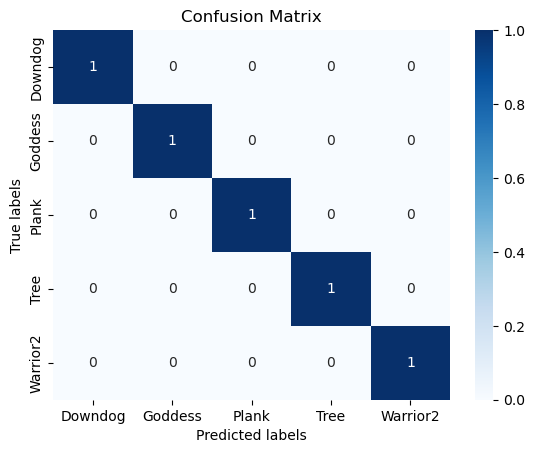

In [379]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


cm_df = pd.DataFrame(cm_normalized, index=img_labels, columns=img_labels)

sns.heatmap(cm_df, annot=True, cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [380]:
cap = cv2.VideoCapture(0)
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
        text = "i don't see you"
        
        if results.pose_landmarks:
            df = pd.DataFrame()
            # Словарь для хранения координат точек тела
            landmarks = {'image_path': str(file_path)}

            for i, landmark in enumerate(results.pose_landmarks.landmark):
                landmarks[f'x_{i}'] = landmark.x
                landmarks[f'y_{i}'] = landmark.y
                landmarks[f'z_{i}'] = landmark.z
                landmarks[f'visibility_{i}'] = landmark.visibility

            # Добавление данных о точках тела в DataFrame
            df = df._append(landmarks, ignore_index=True)
            
            X = np.array(df.iloc[:, 1:])
            text = digits_to_labels[bst.predict(X)[0]]
            
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.putText(image, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()